In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS
import yfinance as yf
from datetime import timedelta

In [344]:
futures = yf.Tickers("CLX21.NYM CLZ21.NYM CLF22.NYM CLG22.NYM CLH22.NYM CLX22.NYM CL=F")
f_hist = futures.history(start='2020-09-01')

[*********************100%***********************]  7 of 7 completed


<AxesSubplot:xlabel='Date'>

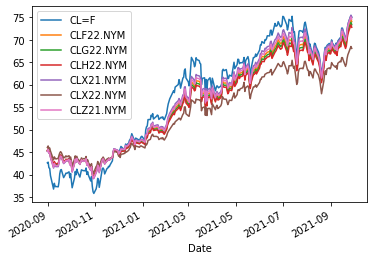

In [345]:
f_hist['Close'].plot()

In [346]:
spot = f_hist['Close']['CL=F']
cl = f_hist['Close'][['CLX21.NYM',  'CLX22.NYM']]
T = [(spot.index[i] - spot.index[0]).days for i in range(1,len(spot))]
spot_model = OLS(np.log(spot[1:]), np.array([T, np.ones(len(T))]).T)
spot_coef = spot_model.fit().params
spot_coef

x1       0.001852
const    3.666460
dtype: float64

In [347]:
gamma = np.zeros(len(cl))*np.nan

for t in range(len(cl)):
    FT = cl.iloc[t]
    T = [i+1 for i in range(len(FT))]
    FT_model = OLS(np.log(FT), np.array([T, np.ones(len(T))]).T)
    FT_coef = FT_model.fit().params
    gamma[t] = -12*FT_coef[0]
gamma = pd.DataFrame(gamma, columns=['gamma'])

In [348]:
lookback = 40
ma = gamma['gamma'].rolling(lookback).mean()
mstd = gamma['gamma'].rolling(lookback).std()
z_score = (gamma['gamma']-ma)/mstd

<AxesSubplot:xlabel='Date'>

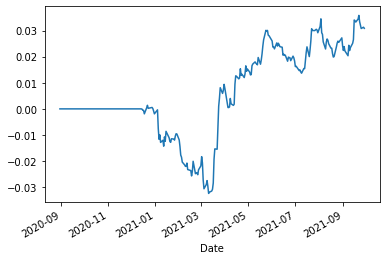

In [349]:
positions = 0 * cl.copy()
z_score.index = positions.index.values

positions['CLX21.NYM'][z_score > 0] = -1
positions['CLX22.NYM'][z_score > 0] = 1

positions['CLX21.NYM'][z_score < 0] = 1
positions['CLX22.NYM'][z_score < 0] = -1


((positions.shift() * cl.pct_change())/2).sum(axis=1).cumsum().plot()

In [355]:
spread = np.log(cl).diff(axis=1)['CLX22.NYM'].fillna(method='ffill').values

In [360]:
adfuller(spread[-100:])

(-2.206403359912451,
 0.2039296208930046,
 2,
 97,
 {'1%': -3.4996365338407074,
  '5%': -2.8918307730370025,
  '10%': -2.5829283377617176},
 -715.7871005787886)

<AxesSubplot:xlabel='Date'>

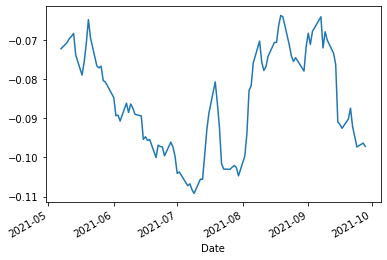

In [359]:
np.log(cl).diff(axis=1)['CLX22.NYM'].fillna(method='ffill')[-100:].plot()

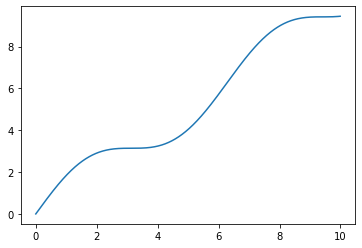

In [369]:
x = [i/100 for i in range(100*10)]
plt.plot(x, np.sin(x) + np.array(x))

In [371]:
adfuller(np.sin(x) + np.array(x))

(0.05930118026742696,
 0.963170001918967,
 20,
 979,
 {'1%': -3.4370471695043037,
  '5%': -2.8644967585264784,
  '10%': -2.5683443301882956},
 -65513.62345319438)